# 설치

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time
import re
# 행 많이보기
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 한글 폰트 설정

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=12)
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer

def mape(A, F): 
    return np.mean(np.abs((A - F) / A)) * 100

def get_dums(dataframe, column_name) :
    return pd.get_dummies(dataframe, columns=[column_name], prefix=str(column_name), drop_first=True)

def tokenizer(x) :
    return x.split()

# 정제 ( 다시 안해도 됨 )

In [16]:
raw_data = pd.read_csv('./data/train_ongoing.csv', encoding='cp949')
category_info = pd.read_excel('./data/result/nouns5/nouns5_result_check.xlsx', encoding='cp949')

In [17]:
# 무이자 일시불 정제

def replace_word(x) :
    x = x.replace('무)', '무이자 ')
    x = x.replace('(무', '무')
    x = x.replace('일)', '일시불 ')
    x = x.replace('(일', '일')
    x = x.replace('(쿠)', '쿠첸')
    return x

brand_df = list(map(replace_word, raw_data['product_name']))

def delete_word(x, word) :
    x = x.replace(word, '')
    return x

f = lambda x, y : delete_word(x, y)

for idx in range(len(brand_df)):
    brand_df[idx] = f(brand_df[idx], '일시불 ')
    brand_df[idx] = f(brand_df[idx], '무이자 ')
    brand_df[idx] = f(brand_df[idx], '일시불')
    brand_df[idx] = f(brand_df[idx], '무이자')    

brand_df = pd.DataFrame(brand_df)
brand_df.columns = ['product_name'] 

In [18]:
# 새로운 category mapping
raw_data['product_name'] = brand_df
raw_data['C1'] = ''*len(raw_data['product_name'])
raw_data['C2'] = ''*len(raw_data['product_name'])
raw_data['C3'] = ''*len(raw_data['product_name'])


for idxx in range(len(raw_data['product_name'])) : # len(df['product_name'])
    infos = category_info.loc[category_info['product_name'] == raw_data['product_name'][idxx]]
    raw_data['C1'][idxx] = infos.iloc[0,1]
    raw_data['C2'][idxx] = infos.iloc[0,2]
    raw_data['C3'][idxx] = infos.iloc[0,3]

C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [21]:
raw_data.drop(['repeat','salesAMT/total','Mcode','new_idx','holiday'], axis=1, inplace=True)
raw_data = raw_data.loc[:,['month', 'day', '요일', 'hour', 'minute', 'exposure_time', 'items','C1','category','C2','C3','mcode','product_code','product_name','price','salesAMT']]
raw_data.columns = ['M', 'D', 'day', 'H', 'min', 'expo_time', 'items', 'C1','category', 'C2', 'C3', 'mcode', 'pcode', 'pname','price', 'salesAMT']

In [22]:
raw_data.to_csv('./data/train_ver2.csv', encoding='cp949', index=False)

In [23]:
raw_data

,M,D,day,H,min,expo_time,items,C1,category,C2,C3,mcode,pcode,pname,price,salesAMT
0,1,1,1,6,0,20.0,2,패션/뷰티,의류,패션의류,남성의류,100346,201072,테이트 남성 셀린니트3종,39900,2099000
1,1,1,1,6,0,20.0,2,패션/뷰티,의류,패션의류,여성의류,100346,201079,테이트 여성 셀린니트3종,39900,4371000
2,1,1,1,6,20,20.0,2,패션/뷰티,의류,패션의류,남성의류,100346,201072,테이트 남성 셀린니트3종,39900,3262000
3,1,1,1,6,20,20.0,2,패션/뷰티,의류,패션의류,여성의류,100346,201079,테이트 여성 셀린니트3종,39900,6955000
4,1,1,1,6,40,20.0,2,패션/뷰티,의류,패션의류,남성의류,100346,201072,테이트 남성 셀린니트3종,39900,6672000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,12,31,1,23,40,20.0,3,홈/라이프스타일,주방,가전/디지털,주방가전,100448,201391,쿠첸압력밥솥 6인용,148000,10157000
37368,12,31,1,24,0,20.0,3,홈/라이프스타일,주방,가전/디지털,주방가전,100448,201383,쿠첸압력밥솥 10인용,178000,50929000
37369,12,31,1,24,0,20.0,3,홈/라이프스타일,주방,가전/디지털,주방가전,100448,201390,쿠첸압력밥솥 10인용,168000,104392000
37370,12,31,1,24,0,20.0,3,홈/라이프스타일,주방,가전/디지털,주방가전,100448,201384,쿠첸압력밥솥 6인용,158000,13765000


# 모델링

In [2]:
df = pd.read_csv('./data/train_ver2.csv', encoding='cp949')

## 결측값 그대로

In [53]:
def mape(A, F): 
    return np.mean(np.abs((A - F) / A)) * 100

def get_dums(dataframe, column_name) :
    return pd.get_dummies(dataframe, columns=[column_name], prefix=str(column_name), drop_first=True)

# for save
df2 = df
for col_name in ['category'] : # 'C1', 'category', 'C2', 'C3'
    df2 = get_dums(df2, col_name)

In [54]:
# train data
X = df2.drop(['C1','C2', 'C3',"salesAMT", 'pname'], axis=1)  #  'C3'
y = df2["salesAMT"] #salesAMT

In [55]:
# train data 내에서 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=147, shuffle=True)

# model 설정
rf_model = RandomForestRegressor(n_estimators=300, n_jobs=-1,)

# 학습
rf_model.fit(X_train, y_train)

# 예측
pred = rf_model.predict(X_test)

# 점수 확인
print('점수 : ',mape(y_test, pred))

# c1, category, c2, c3 : 559 ?
# c3 : 561 ## 화장품/향수
# c2 : 562 ## 패션의류, 주방생활건강, 잡화슈즈주얼리, 유아동, 스포츠레저, 뷰티, 농수축신선식품, 건강다이어트, 가전디지털, 가구침구
# c1 : 563 ## 홈/라이프스타일, 푸드/헬스
# category : 565

점수 :  565.8856436545591


Text(0, 0.5, 'feature')

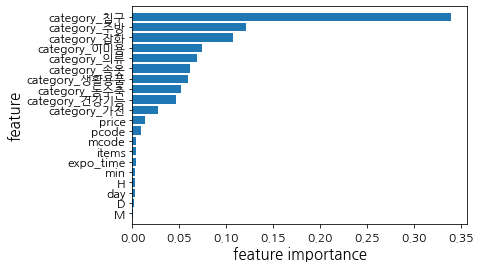

In [56]:
# feature 중요도 확인을 위해서 !
n_feature = X.shape[1]
index = np.arange(n_feature)

featureImportance = rf_model.feature_importances_
#featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])

plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train.keys()[sorted_idx])
plt.yticks(index, X.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

## 결측값 제거

In [3]:
df = pd.read_csv('./data/train_ver2.csv', encoding='cp949')

In [4]:
li_remove = df.loc[df['salesAMT']==50000].index
df_tmp = df.drop(li_remove)

In [82]:
# for save
df2 = df_tmp
for col_name in ['C1', 'category', 'C2', 'C3'] : # 'C1', 'category', 'C2', 'C3'
    df2 = get_dums(df2, col_name)
    
# train data
X = df2.drop(["salesAMT", 'pname'], axis=1)  # 'C1', 'category', 'C2', 'C3'
y = df2["salesAMT"] #salesAMT

# train data 내에서 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=147, shuffle=True)

# model 설정
rf_model = RandomForestRegressor(n_estimators=300, n_jobs=-1,)

# 학습
rf_model.fit(X_train, y_train)

# 예측
pred = rf_model.predict(X_test)

# 점수 확인
print('점수 : ',mape(y_test, pred))

# c1, category, c2, c3 : 60.97
# c3 : 60.57 # 화장품 향수
# c2 : 61 # 패션의류, 주방생활건강, 잡화슈즈쥬얼리, 
# c1 : 61 # 홈라이프스타일, 푸드헬스
# category : 61.1 # 침구, 주방, 잡화, 이미용 

점수 :  60.753933435557215


Text(0, 0.5, 'feature')

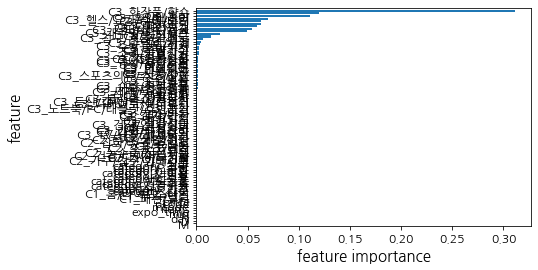

In [83]:
# feature 중요도 확인을 위해서 !
n_feature = X.shape[1]
index = np.arange(n_feature)

featureImportance = rf_model.feature_importances_
#featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])

plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train.keys()[sorted_idx])
plt.yticks(index, X.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

## column 몇 개만 선택해보자_feature importance 높았던 것

In [78]:
df2 = df_tmp
for col_name in ['C1', 'category', 'C2', 'C3'] : # 'C1', 'category', 'C2', 'C3'
    df2 = get_dums(df2, col_name)

In [85]:

df2 = df2.loc[:,['M', 'D', 'day', 'H', 'min', 'expo_time', 'items', 'mcode', 'pcode',
       'pname', 'price', 'salesAMT', 'C1_푸드/헬스', 'C1_홈/라이프스타일','category_이미용', 'category_잡화', 'category_주방',
       'category_침구','C2_잡화/슈즈/쥬얼리','C2_주방/생활/건강', 'C2_패션의류','C3_화장품/향수']]

In [87]:
# train data
X = df2.drop(["salesAMT", 'pname'], axis=1)  # 'C1', 'category', 'C2', 'C3'
y = df2["salesAMT"] #salesAMT

# train data 내에서 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=147, shuffle=True)

# model 설정
rf_model = RandomForestRegressor(n_estimators=500, n_jobs=-1,)

# 학습
rf_model.fit(X_train, y_train)

# 예측
pred = rf_model.predict(X_test)

# 점수 확인
print('점수 : ',mape(y_test, pred))

# c1, category, c2, c3 : 60.97
# c3 : 60.57 # 화장품 향수
# c2 : 61 # 패션의류, 주방생활건강, 잡화슈즈쥬얼리, 
# c1 : 61 # 홈라이프스타일, 푸드헬스
# category : 61.1 # 침구, 주방, 잡화, 이미용 

점수 :  61.362260014245805


## C3 정리 후_RF

In [3]:
df = pd.read_csv('./data/train_ver3.csv', encoding='cp949')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35379 entries, 0 to 35378
Data columns (total 22 columns):
M                                     35379 non-null int64
D                                     35379 non-null int64
day                                   35379 non-null int64
H                                     35379 non-null int64
min                                   35379 non-null int64
expo_time                             35379 non-null float64
items                                 35379 non-null int64
C1                                    35379 non-null object
category                              35379 non-null object
C2                                    35379 non-null object
C3                                    35379 non-null object
mcode                                 35379 non-null int64
pcode                                 35379 non-null int64
pname                                 35379 non-null object
price                                 35379 non-null int64

In [4]:
df = pd.read_csv('./data/train_ver3.csv', encoding='cp949')

# for save
df2 = df
for col_name in ['C1', 'category', 'C2', 'C3'] : # 'C1', 'category', 'C2', 'C3'
    df2 = get_dums(df2, col_name)
    
# train data
X = df2.drop(["salesAMT", 'pname'], axis=1)  # 'C1', 'category', 'C2', 'C3'
y = df2["salesAMT"] #salesAMT

# train data 내에서 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=147, shuffle=True)

# model 설정
rf_model = RandomForestRegressor(n_estimators=300, n_jobs=-1,)

# 학습
rf_model.fit(X_train, y_train)

# 예측
pred = rf_model.predict(X_test)

# 점수 확인
print('점수 : ',mape(y_test, pred))

# 전체 : 60.97
# C3 : 60.66

점수 :  55.87748814344899


Text(0, 0.5, 'feature')

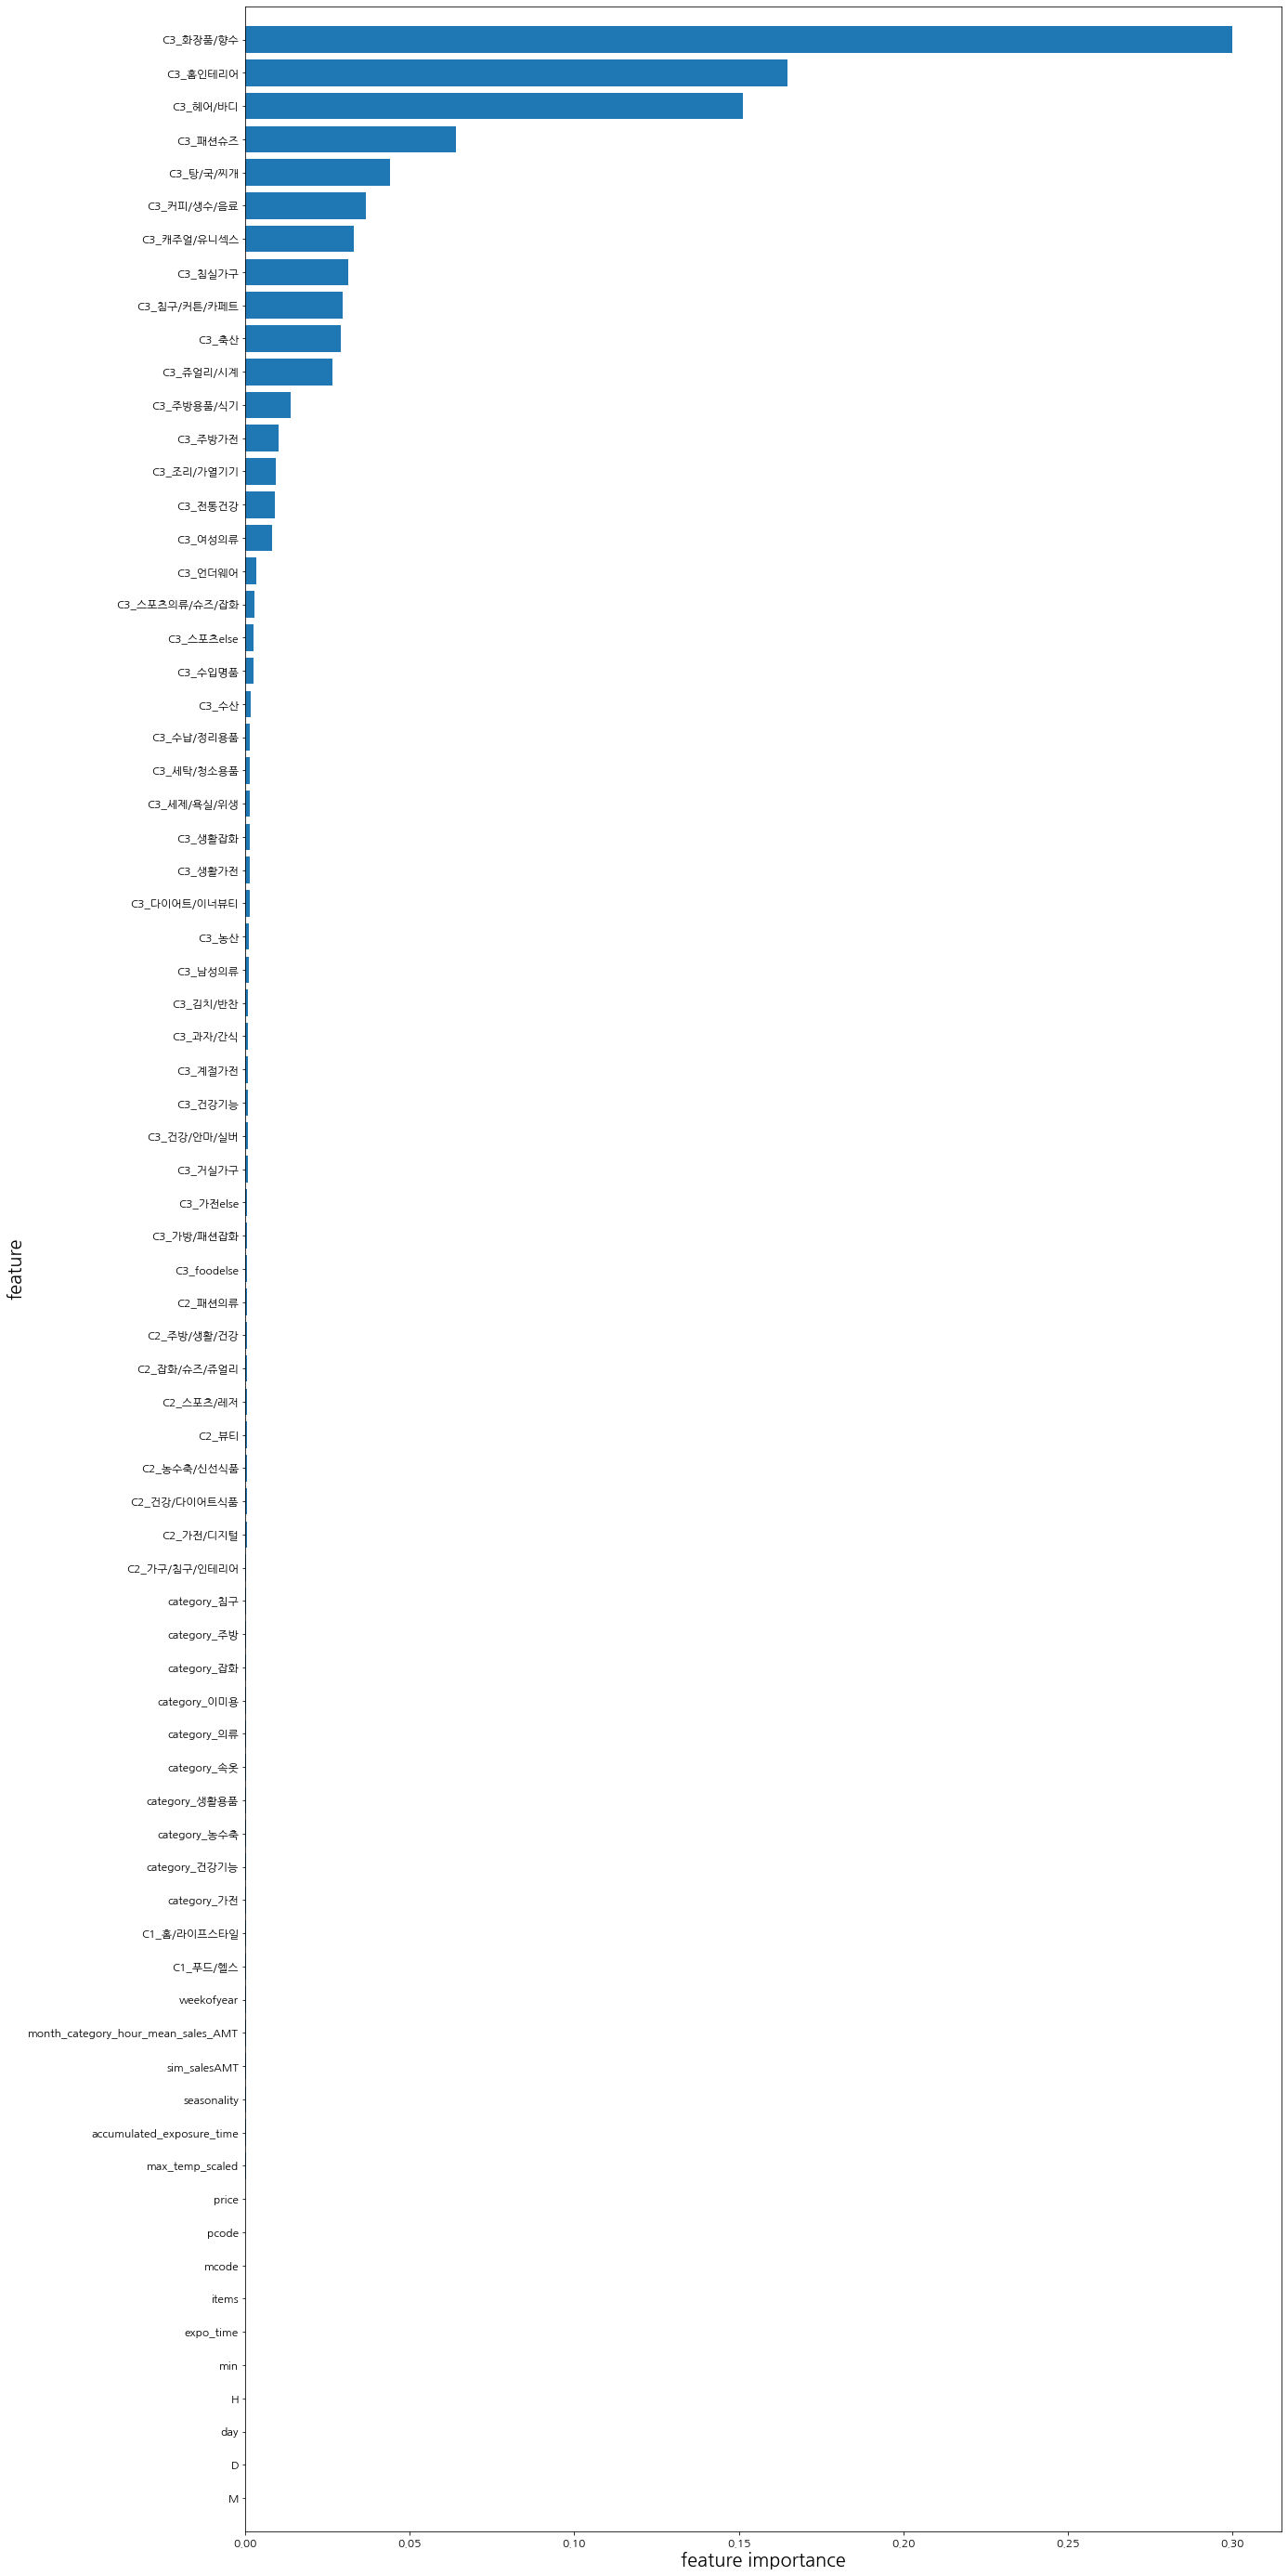

In [5]:
# feature 중요도 확인을 위해서 !
n_feature = X.shape[1]
index = np.arange(n_feature)

featureImportance = rf_model.feature_importances_
#featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(20,50))
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train.keys()[sorted_idx])
plt.yticks(index, X.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=20)
plt.ylabel('feature', size=20)

## LGBM

In [3]:
df = pd.read_csv('./data/train_ver3.csv', encoding='cp949')

In [5]:
features = ['time_month', 'time_day', 'time_hour', 'time_min', 'day_of_the_week',
       'day_of_year', 'quater', 'season', 'expo_time', 'items',  'mcode', 'pcode',  'price', 'sales',
       'FP', 'UFP', 'discomfort_index', 'max_temp_scaled',
       'accumulated_exposure_time', 'seasonality', 'sim_salesAMT',
       'month_category_hour_mean_sales_AMT', 'weekofyear']

# 'C1', 'category', 'C2', 'C3', 'pname',
# , 'salesAMT'

In [6]:
train_X = df.loc[:,features]
train_y = df['salesAMT']

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=147, shuffle=True)

In [34]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from tqdm import trange

In [ ]:
start_time = time.time()
for epoch in trange(10000):    
    model = lgbm.LGBMRegressor(random_state=147, n_estimators=100,learning_rate=0.015)
    model.fit(X_train, y_train)
print("--- %s seconds ---" %(time.time() - start_time))

100%|██████████████████████████████████▉| 9984/10000 [3:19:46<00:15,  1.05it/s]

In [30]:
predicted = model.predict(X_test)
model_score = mape(y_test, predicted)
model_score

1.6667492386522118

Text(0, 0.5, 'feature')

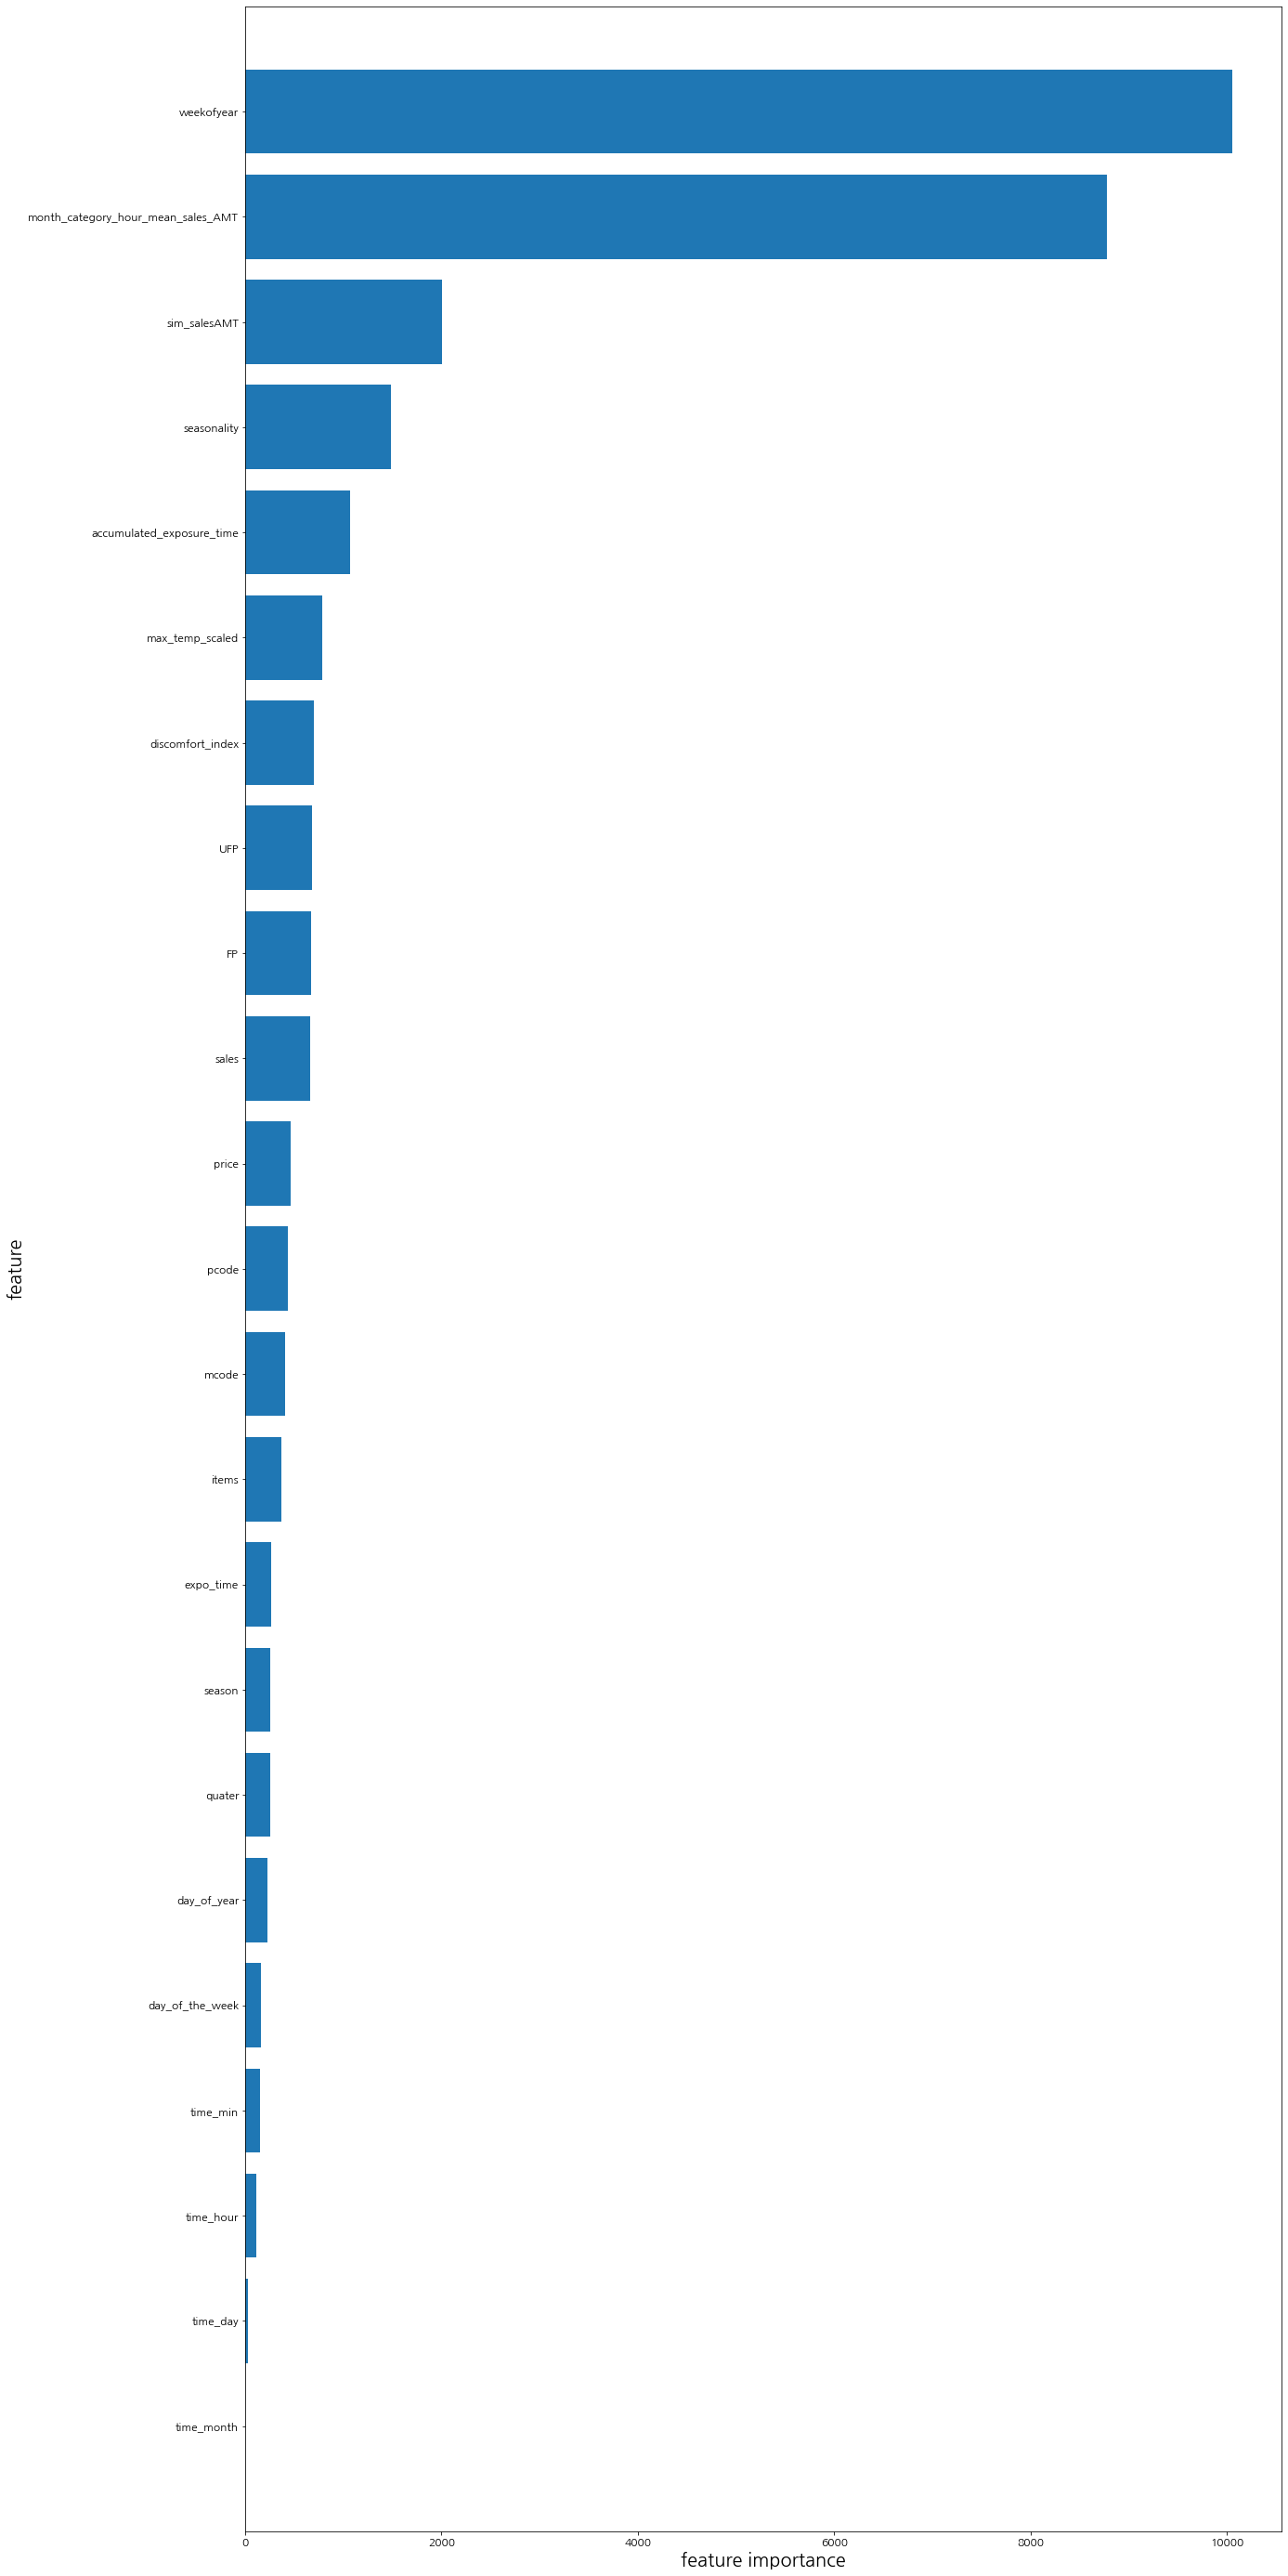

In [28]:
# feature 중요도 확인을 위해서 !
n_feature = train_X.shape[1]
index = np.arange(n_feature)

featureImportance = model.feature_importances_
#featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(20,50))
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train.keys()[sorted_idx])
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=20)
plt.ylabel('feature', size=20)

# 분석

In [3]:
# df = pd.read_csv('./data/train_ver2.csv', encoding='cp949')
# li_remove = df.loc[df['salesAMT']==50000].index
# df_tmp = df.drop(li_remove)

df = pd.read_csv('./data/train_ver3.csv', encoding='cp949')

## C1 분석

### M, C1

<Figure size 3600x1440 with 0 Axes>

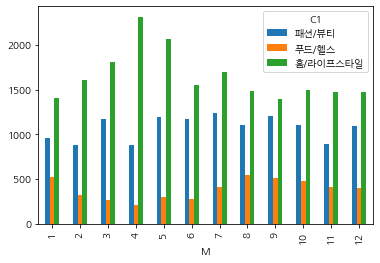

<Figure size 3600x1440 with 0 Axes>

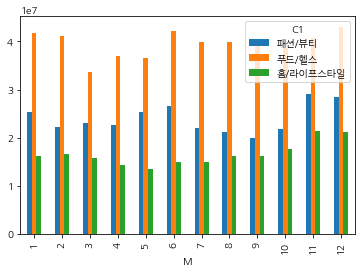

In [18]:
tmp = df.groupby(['M','C1']).count()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

tmp = df.groupby(['M','C1']).mean()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

### D, C1

<Figure size 3600x1440 with 0 Axes>

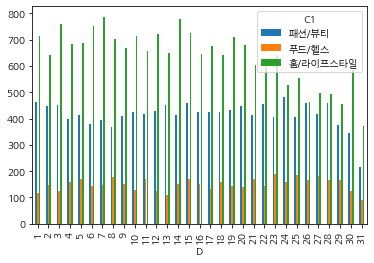

<Figure size 3600x1440 with 0 Axes>

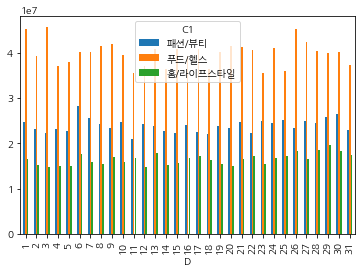

In [17]:
tmp = df.groupby(['D','C1']).count()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

tmp = df.groupby(['D','C1']).mean()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

### DAY, C1

* 푸드/헬스 분야가 주말에 편성개수 대비 매출 평균이 높아짐

<Figure size 3600x1440 with 0 Axes>

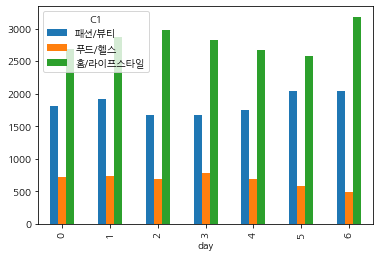

<Figure size 3600x1440 with 0 Axes>

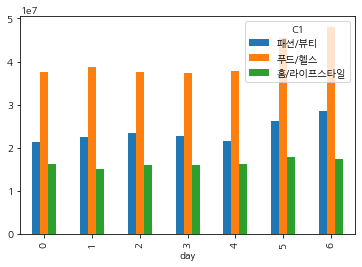

In [19]:
tmp = df.groupby(['day','C1']).count()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

tmp = df.groupby(['day','C1']).mean()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

### H, C1
* 홈/라이프스타일은 저녁 8 - 12 에 밀집되어있고, 편성횟수 대비 평균 판매액은 낮은 편
* 식품은 전반적으로 편성 횟수 대비 평균 판매액이 높음
* 저녁 8-12는 화장품, 식품 또한 편성 횟수 대비 평균 판매액이 높음. 홈/라이프스타일(가구, 전자제품)의 단가가 크기 때문에 판매액을 비교해볼 필요가 있음 !( 1개 비싼거 판다 > 10개 싼거 판다 ? )

<Figure size 3600x1440 with 0 Axes>

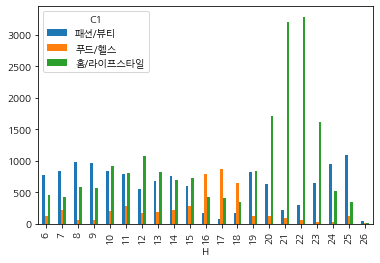

<Figure size 3600x1440 with 0 Axes>

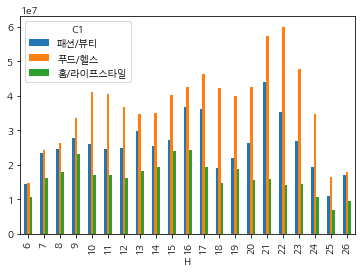

In [20]:
tmp = df.groupby(['H','C1']).count()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

tmp = df.groupby(['H','C1']).mean()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

### items, C1
* 푸드/헬스 : 대부분 1개의 ITEM만 판매
* 패션/뷰티 : 대부분 1,2 개의 ITEM만 판매하지만 가끔 비싼거(명품) 여러개로 팜

-> 1개짜리는 생각보다 다른 C1에 비하여 판매효율이 좋지 않음.

-> 더 비싼 아이템을 배치하면 좋지 않을까 ? ( 싼 아이템을 파는 주 시간대에 )
* 홈/라이프스타일 : X

<Figure size 3600x1440 with 0 Axes>

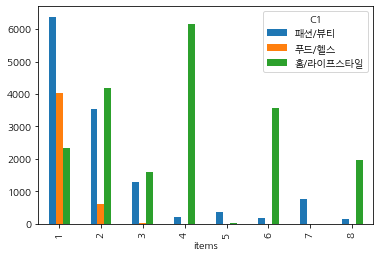

<Figure size 3600x1440 with 0 Axes>

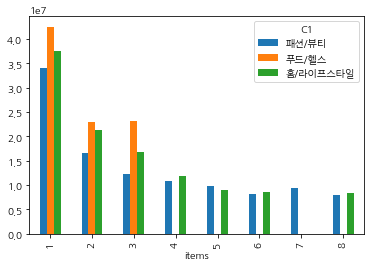

In [22]:
tmp = df.groupby(['items','C1']).count()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

tmp = df.groupby(['items','C1']).mean()['salesAMT']
plt.figure(figsize=(50,20))
plt.rc('font', size=10)
tmp.unstack('C1').plot(kind='bar')

## C2 분석_기존 상품군과 가장 비슷

### M, C2

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 30,10
plt.rc('font', size=20)

## C3분석

### raw !
* 카테고리의 월 편성횟수가 너무 적은 경우 ( 잘 찾지 않는 상품의 경우 )

In [43]:
tmp = df_tmp.groupby(['C3','M']).mean()['salesAMT']
tmp.unstack('C3')

C3,TV/냉장고/세탁기,가방/패션잡화,간편/즉석요리,거실가구,건강/안마/실버,건강기능,계절가전,과자/간식,김치/반찬,남성의류,노트북/PC/태블릿/주변기기,농산,다이어트/이너뷰티,등산/캠핑/낚시/자전거,블랙박스/자동차,생활가전,생활잡화,세제/욕실/위생,세탁/청소용품,수납/정리용품,수납가구,수산,수입명품,스포츠의류/슈즈/잡화,시공/DIY,아동가구,언더웨어,여성의류,영상/음향가전,유아의류/잡화,자동차용품,전통건강,조리/가열기기,주방가구,주방가전,주방용품/식기,쥬얼리/시계,축산,침구/커튼/카페트,침실가구,캐주얼/유니섹스,커피/생수/음료,탕/국/찌개,패션슈즈,헤어/바디,헬스/요가/수영/스키,홈인테리어,홍삼,화장품/향수
M,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.634890e+07,3.238019e+07,NaN,NaN,1.143133e+07,2.492696e+07,1.120336e+07,1.137700e+07,4.251247e+07,2.134549e+07,1.622034e+07,4.067535e+07,NaN,NaN,NaN,3.939971e+07,4.182950e+07,1.521600e+07,NaN,2.118200e+07,NaN,5.016488e+07,NaN,1.754964e+07,NaN,NaN,2.711009e+07,2.007844e+07,NaN,NaN,NaN,3.612822e+07,2.632512e+07,NaN,1.094047e+07,3.458959e+07,1.169728e+07,3.306327e+07,NaN,NaN,3.443002e+07,1.004833e+07,4.254881e+07,7.149833e+06,1.092633e+07,NaN,NaN,14950375.0,3.897761e+07
2,1.929753e+07,3.288091e+07,NaN,NaN,6.571143e+06,2.726667e+07,NaN,NaN,3.952128e+07,1.324935e+07,1.776748e+07,3.824974e+07,NaN,NaN,NaN,4.371704e+07,NaN,1.570267e+07,NaN,1.663189e+07,NaN,4.403154e+07,NaN,NaN,5.796812e+06,NaN,1.788440e+07,2.797534e+07,NaN,NaN,NaN,3.633935e+07,1.904008e+07,NaN,1.088871e+07,3.824568e+07,8.718444e+06,NaN,NaN,1.436349e+07,2.352151e+07,NaN,3.697189e+07,2.045765e+07,1.375383e+07,2.822317e+07,NaN,NaN,3.452100e+07
3,2.093858e+07,2.146721e+07,NaN,8.456286e+06,5.987533e+07,2.463440e+07,1.766101e+07,NaN,3.473693e+07,1.797354e+07,1.488545e+07,4.014782e+07,NaN,2.119800e+07,NaN,2.816968e+07,1.055825e+07,2.036560e+07,1.607153e+07,2.005309e+07,NaN,3.607806e+07,NaN,2.246658e+07,6.633184e+06,NaN,2.494846e+07,2.436830e+07,NaN,NaN,1.504100e+07,2.534021e+07,2.108425e+07,NaN,9.945072e+06,2.919920e+07,6.617083e+06,NaN,NaN,1.251881e+07,2.388772e+07,NaN,3.419880e+07,1.645642e+07,1.376367e+07,1.564805e+07,NaN,NaN,3.641852e+07
4,1.627866e+07,2.006459e+07,1.154067e+07,NaN,1.029550e+07,2.261688e+07,1.764856e+07,2.403273e+07,5.151900e+07,2.148034e+07,NaN,4.533932e+07,1.010833e+07,2.001175e+07,NaN,2.664737e+07,NaN,1.579367e+07,1.026629e+07,1.312569e+07,NaN,4.686759e+07,8.361000e+06,2.087779e+07,1.562821e+07,NaN,2.784060e+07,1.604839e+07,NaN,2.383333e+06,1.092917e+07,2.101100e+07,2.216864e+07,NaN,1.002841e+07,2.881884e+07,4.438417e+06,3.258700e+07,5.049761e+06,1.101013e+07,1.820350e+07,NaN,3.806367e+07,1.900100e+07,9.262455e+06,NaN,NaN,NaN,3.331826e+07
5,1.452989e+07,1.969777e+07,NaN,7.891139e+06,1.483072e+07,1.914017e+07,1.495731e+07,2.063767e+07,4.835311e+07,2.554228e+07,9.154556e+06,5.094206e+07,4.607333e+07,NaN,NaN,2.598139e+07,NaN,6.738333e+06,2.192092e+07,1.834980e+07,NaN,4.026681e+07,1.399551e+07,1.937397e+07,1.105445e+07,NaN,3.203826e+07,2.419006e+07,NaN,1.649267e+07,NaN,1.829778e+07,2.119253e+07,NaN,1.021651e+07,2.628736e+07,NaN,3.045017e+07,1.144249e+07,1.326381e+07,1.839171e+07,NaN,6.032597e+07,2.336596e+07,1.072419e+07,NaN,NaN,NaN,4.072902e+07
6,1.909373e+07,1.271797e+07,NaN,8.247969e+06,1.114742e+07,2.580713e+07,1.072701e+07,NaN,4.164900e+07,2.437238e+07,NaN,4.714915e+07,4.255852e+07,NaN,NaN,2.410122e+07,NaN,2.201147e+07,1.514900e+07,4.260222e+06,NaN,4.853519e+07,2.010300e+07,1.877293e+07,7.351273e+06,NaN,3.722654e+07,2.339728e+07,NaN,NaN,NaN,3.070632e+07,2.896402e+07,NaN,1.094792e+07,3.136034e+07,NaN,NaN,1.446756e+07,1.474602e+07,1.551576e+07,NaN,4.884042e+07,1.667875e+07,3.095383e+07,NaN,NaN,NaN,3.770710e+07
7,1.982695e+07,1.335220e+07,NaN,9.923237e+06,NaN,2.319108e+07,9.909585e+06,1.126870e+07,4.229319e+07,2.732932e+07,NaN,4.156489e+07,3.502313e+07,NaN,NaN,2.378591e+07,NaN,3.745367e+07,1.060800e+07,1.160584e+07,NaN,4.298027e+07,1.280312e+07,1.982350e+07,NaN,5.266029e+06,2.471080e+07,2.928463e+07,NaN,NaN,NaN,2.422800e+07,2.602988e+07,NaN,1.138201e+07,2.705145e+07,1.324427e+07,NaN,1.122410e+07,1.414595e+07,2.152822e+07,NaN,4.508363e+07,2.342302e+07,NaN,NaN,NaN,NaN,3.370300e+07
8,2.130097e+07,8.897912e+06,NaN,1.043438e+07,9.997500e+06,2.243957e+07,1.377059e+07,3.729747e+07,3.435439e+07,3.691048e+07,NaN,3.856969e+07,2.631333e+07,NaN,NaN,1.780995e+07,8.565188e+0

In [44]:
df_tmp.groupby(['C3','M']).count()['salesAMT'].unstack('C3')

C3,TV/냉장고/세탁기,가방/패션잡화,간편/즉석요리,거실가구,건강/안마/실버,건강기능,계절가전,과자/간식,김치/반찬,남성의류,노트북/PC/태블릿/주변기기,농산,다이어트/이너뷰티,등산/캠핑/낚시/자전거,블랙박스/자동차,생활가전,생활잡화,세제/욕실/위생,세탁/청소용품,수납/정리용품,수납가구,수산,수입명품,스포츠의류/슈즈/잡화,시공/DIY,아동가구,언더웨어,여성의류,영상/음향가전,유아의류/잡화,자동차용품,전통건강,조리/가열기기,주방가구,주방가전,주방용품/식기,쥬얼리/시계,축산,침구/커튼/카페트,침실가구,캐주얼/유니섹스,커피/생수/음료,탕/국/찌개,패션슈즈,헤어/바디,헬스/요가/수영/스키,홈인테리어,홍삼,화장품/향수
M,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,374.0,31.0,NaN,NaN,30.0,24.0,11.0,12.0,17.0,153.0,74.0,55.0,NaN,NaN,NaN,51.0,2.0,3.0,NaN,12.0,NaN,259.0,NaN,14.0,NaN,NaN,391.0,151.0,NaN,NaN,NaN,54.0,113.0,NaN,492.0,118.0,72.0,41.0,NaN,NaN,58.0,3.0,32.0,6.0,6.0,NaN,NaN,24.0,87.0
2,361.0,47.0,NaN,NaN,28.0,9.0,NaN,NaN,18.0,48.0,150.0,39.0,NaN,NaN,NaN,48.0,NaN,6.0,NaN,37.0,NaN,191.0,NaN,NaN,16.0,NaN,365.0,200.0,NaN,NaN,NaN,54.0,127.0,NaN,388.0,118.0,36.0,NaN,NaN,193.0,45.0,NaN,9.0,48.0,6.0,6.0,NaN,NaN,84.0
3,264.0,97.0,NaN,7.0,6.0,45.0,109.0,NaN,15.0,235.0,118.0,22.0,NaN,2.0,NaN,87.0,8.0,15.0,30.0,88.0,NaN,158.0,NaN,77.0,38.0,NaN,405.0,300.0,NaN,NaN,3.0,14.0,56.0,NaN,346.0,143.0,12.0,NaN,NaN,217.0,18.0,NaN,15.0,45.0,3.0,21.0,NaN,NaN,52.0
4,570.0,94.0,3.0,NaN,8.0,33.0,73.0,33.0,9.0,154.0,NaN,37.0,3.0,4.0,NaN,43.0,NaN,6.0,24.0,65.0,NaN,68.0,4.0,207.0,14.0,NaN,306.0,167.0,NaN,6.0,6.0,1.0,89.0,NaN,398.0,213.0,12.0,12.0,46.0,266.0,48.0,NaN,9.0,23.0,11.0,NaN,NaN,NaN,66.0
5,438.0,217.0,NaN,72.0,36.0,42.0,423.0,54.0,35.0,180.0,9.0,17.0,3.0,NaN,NaN,18.0,NaN,6.0,12.0,20.0,NaN,99.0,81.0,39.0,20.0,NaN,344.0,246.0,NaN,3.0,NaN,9.0,93.0,NaN,197.0,179.0,NaN,6.0,81.0,151.0,21.0,NaN,32.0,24.0,16.0,NaN,NaN,NaN,54.0
6,192.0,112.0,NaN,96.0,12.0,45.0,254.0,NaN,30.0,185.0,NaN,20.0,27.0,NaN,NaN,9.0,NaN,15.0,6.0,9.0,NaN,91.0,68.0,27.0,11.0,NaN,367.0,244.0,NaN,NaN,NaN,22.0,133.0,NaN,218.0,132.0,NaN,NaN,162.0,129.0,51.0,NaN,48.0,73.0,12.0,NaN,NaN,NaN,60.0
7,330.0,163.0,NaN,59.0,NaN,36.0,130.0,10.0,36.0,102.0,NaN,36.0,30.0,NaN,NaN,43.0,NaN,6.0,11.0,25.0,NaN,148.0,118.0,18.0,NaN,35.0,368.0,182.0,NaN,NaN,NaN,8.0,160.0,NaN,245.0,144.0,81.0,NaN,183.0,129.0,36.0,NaN,105.0,63.0,NaN,NaN,NaN,NaN,92.0
8,289.0,113.0,NaN,82.0,10.0,35.0,32.0,51.0,87.0,60.0,NaN,39.0,3.0,NaN,NaN,182.0,48.0,3.0,3.0,21.0,NaN,184.0,15.0,42.0,NaN,NaN,296.0,165.0,13.0,NaN,NaN,6.0,180.0,NaN,196.0,92.0,158.0,27.0,12.0,108.0,99.0,6.0,111.0,36.0,6.0,NaN,NaN,NaN,90.0
9,259.0,163.0,NaN,105.0,24.0,30.0,27.0,24.0,48.0,101.0,NaN,9.0,NaN,NaN,12.0,66.0,48.0,15.0,6.0,25.0,11.0,192.0,37.0,42.0,NaN,NaN,191.0,237.0,6.0,NaN,NaN,36.0,99.0,NaN,282.0,91.0,132.0,39.0,57.0,115.0,62.0,57.0,78.0,87.0,42.0,NaN,NaN,NaN,126.0


### 카테고리의 월 편성횟수가 너무 적은 제품은 합해주기

In [ ]:
* # 간편/즉석요리 # 홍삼 
* # 수납가구 # 홈인테리어 # 시공/DIY # 아동가구 # 주방가구  
* # 노트북/PC/태블릿/주변기기 # 영상/음향가전 # 블랙박스/자동차
* # 등산/캠핑/낚시/자전거 # 자동차용품 # 헬스/요가/수영/스키
* # 생활잡화 
* # 유아의류/잡화 -> 캐쥬얼/유니섹스

In [45]:
df_tmp.loc[df_tmp['C3']=='간편/즉석요리', 'C3'] = 'foodelse'
df_tmp.loc[df_tmp['C3']=='홍삼','C3'] = 'foodelse'

df_tmp.loc[df_tmp['C3']=='수납가구', 'C3'] = '홈인테리어' 
df_tmp.loc[df_tmp['C3']=='시공/DIY', 'C3']  = '홈인테리어'
df_tmp.loc[df_tmp['C3']=='아동가구', 'C3']  = '홈인테리어'
df_tmp.loc[df_tmp['C3']=='주방가구', 'C3']  = '홈인테리어'

df_tmp.loc[df_tmp['C3']=='노트북/PC/태블릿/주변기기', 'C3']  = '가전else'
df_tmp.loc[df_tmp['C3']=='영상/음향가전', 'C3']  = '가전else'
df_tmp.loc[df_tmp['C3']=='블랙박스/자동차', 'C3']  = '가전else'

df_tmp.loc[df_tmp['C3']=='등산/캠핑/낚시/자전거', 'C3']  = '스포츠else'
df_tmp.loc[df_tmp['C3']=='자동차용품', 'C3']  = '스포츠else'
df_tmp.loc[df_tmp['C3']=='헬스/요가/수영/스키', 'C3']  = '스포츠else'

df_tmp.loc[df_tmp['C3']=='유아의류/잡화', 'C3'] = '캐주얼/유니섹스' # 홈/라이프스타일, # 유아동으로 C1, C2 변경

In [36]:
df_tmp.loc[df_tmp['C3']=='생활잡화'] # 공구세트, 교자상, 도어락 # 공구세트는 언제 파는거지 ? 교자상은 추석 전쯤 # 도어락은 저녁시간대 판매

,M,D,day,H,min,expo_time,items,C1,category,C2,C3,mcode,pcode,pname,price,salesAMT
526,1,6,6,24,0,30,1,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100433,201346,스위스밀리터리 전동공구세트,138000,25755000
527,1,6,6,24,30,30,1,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100433,201346,스위스밀리터리 전동공구세트,138000,57904000
5925,3,2,5,25,0,30,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202164,김병만의 달인 공구 세트,178000,7787000
5926,3,2,5,25,0,30,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202167,김병만의 달인 공구 세트,173000,4197000
5927,3,2,5,25,30,26.0333,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202164,김병만의 달인 공구 세트,178000,9861000
5928,3,2,5,25,30,26.0333,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202167,김병만의 달인 공구 세트,173000,10914000
6463,3,7,3,24,0,30,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202164,김병만의 달인 공구 세트,178000,7747000
6464,3,7,3,24,0,30,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202167,김병만의 달인 공구 세트,173000,4116000
6465,3,7,3,24,30,30,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202164,김병만의 달인 공구 세트,178000,17506000
6466,3,7,3,24,30,30,2,홈/라이프스타일,생활용품,주방/생활/건강,생활잡화,100737,202167,김병만의 달인 공구 세트,173000,22338000


In [52]:
df_tmp.groupby(['C1','C2','C3','M']).count()['salesAMT'].unstack(['C1','C2','C3'])

C1 패션/뷰티                                                                    \
C2    뷰티        잡화/슈즈/쥬얼리                        패션의류                        
C3 헤어/바디 화장품/향수   가방/패션잡화   수입명품 쥬얼리/시계  패션슈즈 가방/패션잡화   남성의류   언더웨어   여성의류   
M                                                                            
1    6.0   87.0      31.0    NaN   72.0   6.0     NaN  153.0  391.0  151.0   
2    6.0   84.0      47.0    NaN   36.0  48.0     NaN   48.0  365.0  200.0   
3    3.0   52.0      97.0    NaN   12.0  33.0     NaN  235.0  405.0  300.0   
4   11.0   66.0      94.0    4.0   12.0  23.0     NaN  154.0  306.0  167.0   
5   16.0   54.0     217.0   81.0    NaN  24.0     NaN  180.0  344.0  246.0   
6   12.0   60.0     112.0   68.0    NaN  71.0     NaN  185.0  367.0  244.0   
7    NaN   92.0     163.0  118.0   81.0  63.0     NaN  102.0  368.0  182.0   
8    6.0   90.0     113.0   15.0  158.0  36.0     NaN   60.0  296.0  165.0   
9   42.0  126.0     163.0   37.0  132.0  84.0     NaN  101.0  191.0  237.0   
10  25.0  146.0      67.0   43.0  151.0  68.0     NaN  105.0  233.0  161.0   
11  18.0  166.0      56.0   18.0   43.0  33.0     9.0   73.0  243.0  157.0   
12  17.0  214.0      86.0   51.0   10.0  55.0    10.0   74.0  280.0  235.0   

C1                   푸드/헬스                                              \
C2                    가공식품                             건강/다이어트식품         
C3 캐주얼/유니섹스  패션슈즈 foodelse 과자/간식 김치/반찬 커피/생수/음료 탕/국/찌개  foodelse  건강기능   
M                                                                        
1      58.0   NaN      NaN  12.0  17.0      3.0   32.0      24.0  24.0   
2      45.0   NaN      NaN   NaN  18.0      NaN    9.0       NaN   9.0   
3      18.0  12.0      NaN   NaN  15.0      NaN   15.0       NaN  45.0   
4      48.0   NaN      3.0  33.0   9.0      NaN    9.0       NaN  33.0   
5      21.0   NaN      NaN  54.0  35.0      NaN   32.0       NaN  42.0   
6      51.0   2.0      NaN   NaN  30.0      NaN   48.0       NaN  45.0   
7      36.0   NaN      NaN  10.0  36.0      NaN  105.0       NaN  36.0   
8      99.0   NaN      NaN  51.0  87.0      6.0  111.0       NaN  35.0   
9      62.0   3.0      NaN  24.0  48.0     57.0   78.0       NaN  30.0   
10     58.0   3.0      NaN  25.0  48.0      6.0   72.0       NaN  40.0   
11     51.0  12.0      NaN   6.0  20.0     26.0   53.0       NaN  41.0   
12     41.0  12.0      3.0   NaN   5.0     33.0   77.0       NaN  39.0   

C1                                         홈/라이프스타일                         \
C2                 농수축/신선식품              가구/침구/인테리어                          
C3 다이어트/이너뷰티  전통건강       농산     수산    축산       거실가구 침구/커튼/카페트   침실가구 홈인테리어   
M                                                                            
1        NaN  54.0     55.0  259.0  41.0        NaN       NaN    NaN   NaN   
2        NaN  54.0     39.0  191.0   NaN        NaN       NaN  193.0  16.0   
3        NaN  14.0     22.0  158.0   NaN        7.0       NaN  217.0  38.0   
4        3.0   1.0     37.0   68.0  12.0        NaN      46.0  266.0  14.0   
5        3.0   9.0     17.0   99.0   6.0       72.0      81.0  151.0  20.0   
6       27.0  22.0     20.0   91.0   NaN       96.0     162.0  129.0  11.0   
7       30.0   8.0     36.0  148.0   NaN       59.0     183.0  129.0  35.0   
8        3.0   6.0     39.0  184.0  27.0       82.0      12.0  108.0   NaN   
9        NaN  36.0      9.0  192.0  39.0      105.0      57.0  115.0  11.0   
10       6.0  41.0     34.0  158.0  48.0       79.0      60.0  111.0  15.0   
11      17.0  18.0     38.0  172.0  21.0       47.0      90.0   81.0  40.0   
12       3.0  27.0     23.0  174.0  21.0       12.0       NaN  129.0  18.0   

C1                                                                     \
C2     가전/디지털                                      스포츠/레저               
C3 TV/냉장고/세탁기 가전else   계절가전   생활가전 조리/가열기기   주방가전 스포츠else 스포츠의류/슈즈/잡화   
M                                                                       
1       374.0   74.0   11

In [57]:
# df_tmp.to_csv('./data/train_ver3.csv', encoding='cp949', index=False)

### M, C3

In [124]:
tmp.fillna(0, inplace=True)

TypeError: no numeric data to plot

<Figure size 3600x1440 with 0 Axes>

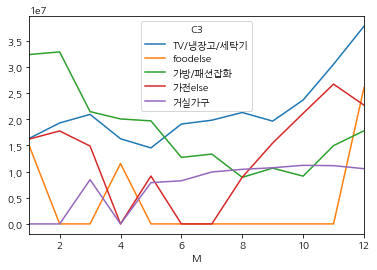

<Figure size 3600x1440 with 0 Axes>

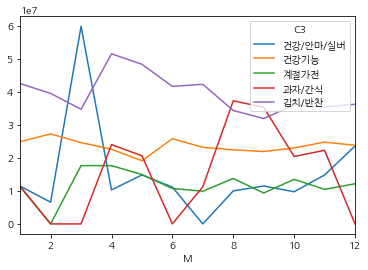

<Figure size 3600x1440 with 0 Axes>

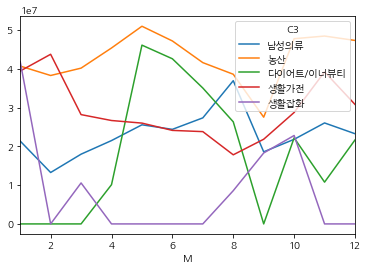

<Figure size 3600x1440 with 0 Axes>

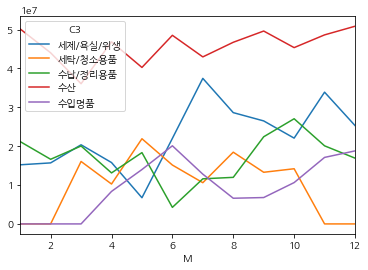

<Figure size 3600x1440 with 0 Axes>

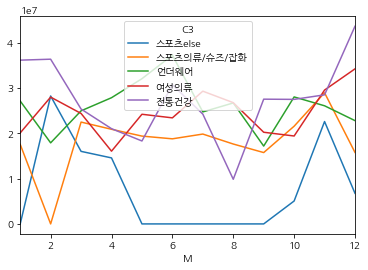

<Figure size 3600x1440 with 0 Axes>

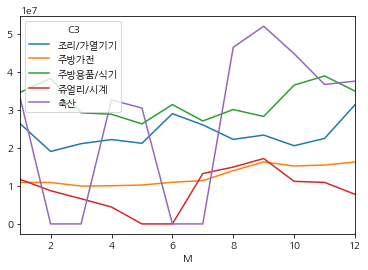

<Figure size 3600x1440 with 0 Axes>

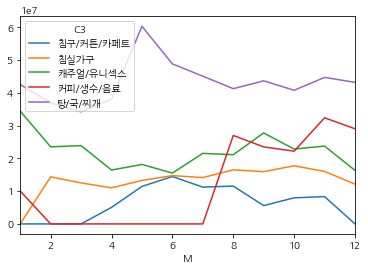

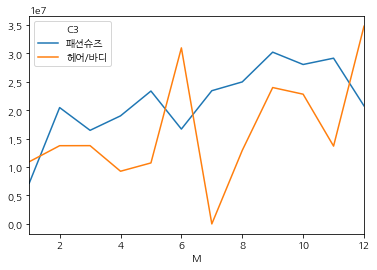

In [132]:
tmp = df.groupby(['M','C3']).mean()['salesAMT']

for c3 in range(0, len(tmp), 5) :
    if c3 < 35 :
        plt.figure(figsize=(50,20))
        plt.rc('font', size=10)
        tmp.unstack('C3').fillna(0).iloc[:,c3:c3+5].plot()
    else :
        tmp.unstack('C3').fillna(0).iloc[:,c3:c3+2].plot()

In [ ]:
* tv/냉장고/세탁기 : 겨울에 엄청 평균 취급액 높음
* 12 월에 foodelse 갑자기 편성됨, 매출액 높은 편
* 가방/패션잡화 : 연초에 높은편
* 가전else : 연말에 많은편 
* 건강/안마/실버 : 2,3월에 높은편(마스크 ??!!)
* 김치/반찬 : 전체적으로 높은편
* 과자/간식 : 가을쯤 높아짐(추석 영향있는 제품들인지 확인 필요)
* 계절가전 : count 확인 필요
* 농산 : 9월에 갑자기 감소하는편 , 이유는 ? ( 추석 후에 편성 및 판매액이 감소할 수 있음)
* 다이어트 / 이너뷰티 : count 확인 필요
* 생활가전 : 11 ~ 1 높은 편
* 수산 : 꾸준히 높은 매출 
* 세제/욕실/위생 : 여름에 높다 ? 
* 수납/정리용품 : 계절 바뀔때 높은 편
* 수입명품 : 6, 11, 12월 높음 => 가장 아무것도 없는 달 ?
* 스포츠else : 2, 11월 높음
* 언더웨어 : 여름
* 전통건강 : 겨울
* 축산 : 추석쯤에 수산과 비교해서 매우 높음
* 커피, 생수, 음료 : 상품 확인 필요
* 헤어/바디 : 6월, 12월

### day, C3

TypeError: no numeric data to plot

<Figure size 3600x1440 with 0 Axes>

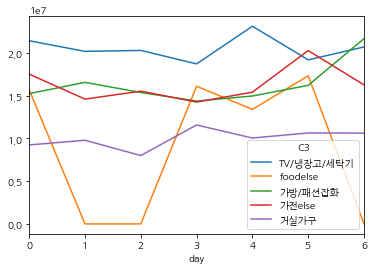

<Figure size 3600x1440 with 0 Axes>

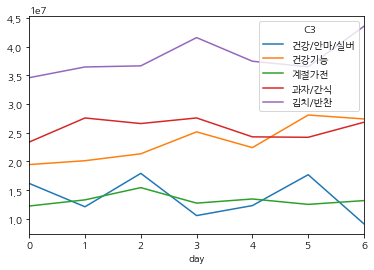

<Figure size 3600x1440 with 0 Axes>

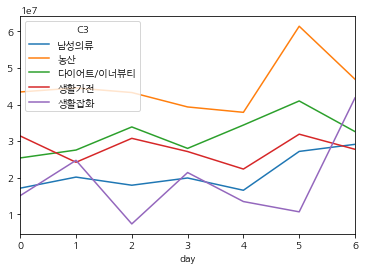

<Figure size 3600x1440 with 0 Axes>

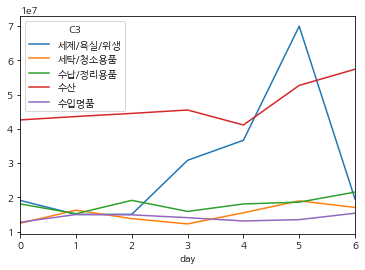

<Figure size 3600x1440 with 0 Axes>

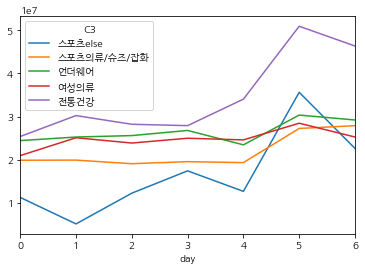

<Figure size 3600x1440 with 0 Axes>

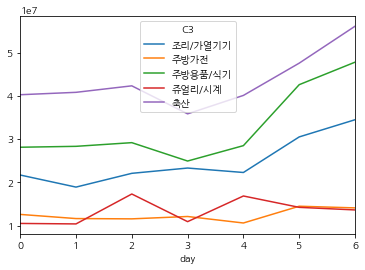

<Figure size 3600x1440 with 0 Axes>

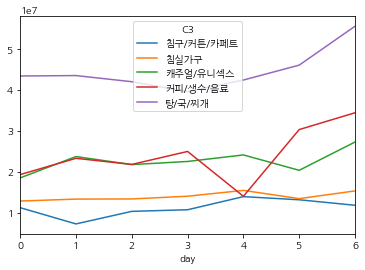

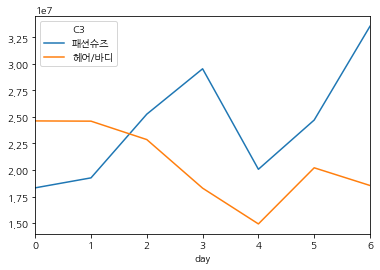

In [138]:
tmp = df.groupby(['day','C3']).mean()['salesAMT']

for c3 in range(0, len(tmp), 5) :
    if c3 < 35 :
        plt.figure(figsize=(50,20))
        plt.rc('font', size=10)
        tmp.unstack('C3').fillna(0).iloc[:,c3:c3+5].plot()
    else :
        tmp.unstack('C3').fillna(0).iloc[:,c3:c3+2].plot()

### H, C3

TypeError: no numeric data to plot

<Figure size 3600x1440 with 0 Axes>

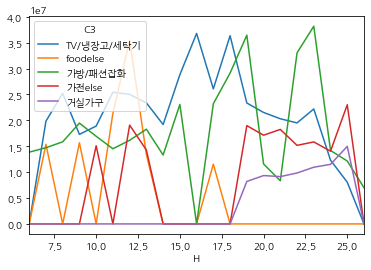

<Figure size 3600x1440 with 0 Axes>

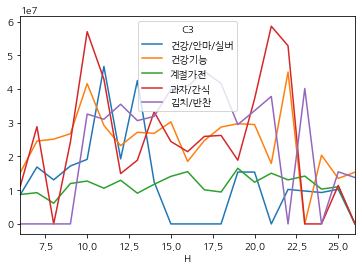

<Figure size 3600x1440 with 0 Axes>

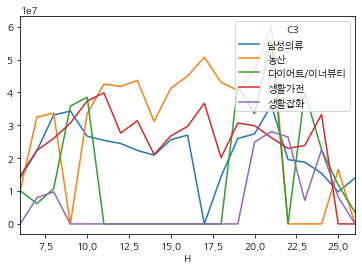

<Figure size 3600x1440 with 0 Axes>

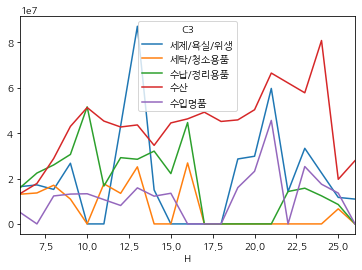

<Figure size 3600x1440 with 0 Axes>

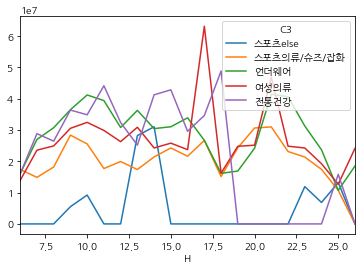

<Figure size 3600x1440 with 0 Axes>

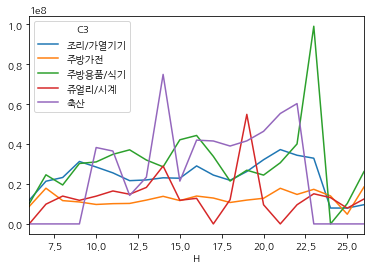

<Figure size 3600x1440 with 0 Axes>

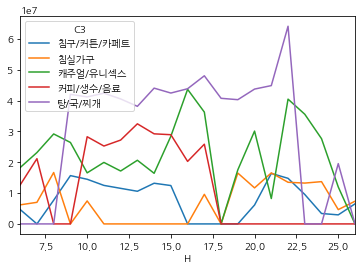

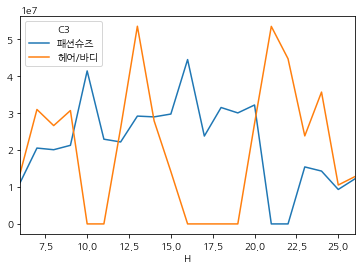

In [139]:
tmp = df.groupby(['H','C3']).mean()['salesAMT']

for c3 in range(0, len(tmp), 5) :
    if c3 < 35 :
        plt.figure(figsize=(50,20))
        plt.rc('font', size=10)
        tmp.unstack('C3').fillna(0).iloc[:,c3:c3+5].plot()
    else :
        tmp.unstack('C3').fillna(0).iloc[:,c3:c3+2].plot()

### 카테고리별로 어떤 단어가 많이 등장하는지
-> 큰 의미 없음

In [96]:
category_list = list(df['C3'].unique())
for one_category in category_list :
    tmp1 = pd.DataFrame(df.loc[df['C3'] == one_category, 'pname'])

    vect = CountVectorizer(tokenizer=tokenizer, min_df=1, binary=False, ngram_range=(1, 1)) # , stop_words=['삼성카드']
    #print(vector.fit_transform(tmp1['product_name']).toarray()) # 코퍼스로부터 각 단어의 빈도 수를 기록한다.
    vect.fit(tmp1['pname'])
    bow = vect.vocabulary_
    bow_df = pd.DataFrame(bow.values(), index = bow.keys() )
    bow_df.sort_values(0, axis=0, inplace=True, ascending = False)
    bow_df['word freq'] = bow_df[0]
    bow_df.drop(0, axis=1, inplace = True)
    bow_df['freq rate(%)'] = bow_df['word freq']*100 / len(tmp1)
    print('-----------------------', one_category, len(tmp1), '-------------------------')
    display(bow_df.head(10))

----------------------- 남성의류 1470 -------------------------


,word freq,freq rate(%)
화이트라벨,194,13.197279
헤스티지,193,13.129252
헤비추얼,192,13.061224
헤드,191,12.993197
플렉스,190,12.925170
프린트티셔츠8종,189,12.857143
풀패키지,188,12.789116
폴로셔츠,187,12.721088
퍼포먼스,186,12.653061
팬츠3종(2019,185,12.585034


----------------------- 여성의류 2445 -------------------------


,word freq,freq rate(%)
휘메일,296,12.106339
후드코트(앱할인),295,12.065440
후드코트,294,12.024540
후드롱구스다운코트,293,11.983640
후드,292,11.942740
화이트라벨,291,11.901840
헤어볼륨쿠션,290,11.860941
헤스티지,289,11.820041
헤비추얼,288,11.779141
헤드,287,11.738241


----------------------- 언더웨어 3789 -------------------------


,word freq,freq rate(%)
힐링,305,8.049617
히팅,304,8.023225
히트융,303,7.996833
히트모,302,7.970441
후크,301,7.944049
황후의코르셋,300,7.917656
황후의,299,7.891264
홈웨어세트,298,7.864872
홈웨어,297,7.838480
홀리데이,296,7.812088


----------------------- 주방용품/식기 1556 -------------------------


,word freq,freq rate(%)
후레쉬,154,9.897172
후라이팬,153,9.832905
회전통그릴,152,9.768638
홈쿠(시즌2),151,9.704370
홈세트,150,9.640103
홈밀맷돌,149,9.575835
호주,148,9.511568
해피콜,147,9.447301
해물철판,146,9.383033
항균도마,145,9.318766


----------------------- 탕/국/찌개 641 -------------------------


,word freq,freq rate(%)
한우소머리양곰탕,50,7.800312
한우소머리,49,7.644306
풀세트,48,7.488300
특갈비탕,47,7.332293
통뼈,46,7.176287
탕요일,45,7.020281
창녕,44,6.864275
재첩국,43,6.708268
임성근의,42,6.552262
이봉원,41,6.396256


----------------------- 수산 1894 -------------------------


,word freq,freq rate(%)
홍어,125,6.599789
현대어찬,124,6.546990
햇,123,6.494192
해죽순,122,6.441394
하늘내린,121,6.388596
피시원,120,6.335797
피꼬막,119,6.282999
포항구룡포과메기세트,118,6.230201
특大손질갑오징어,117,6.177402
통오징어,116,6.124604


----------------------- 농산 369 -------------------------


,word freq,freq rate(%)
흥양농협,44,11.924119
황토방,43,11.653117
햅쌀,42,11.382114
한라봉2박스+천혜향1박스,41,11.111111
캘리포니아,40,10.840108
카라카라,39,10.569106
총,38,10.298103
청도,37,10.027100
찰,36,9.756098
제주,35,9.485095


----------------------- 화장품/향수 1237 -------------------------


,word freq,freq rate(%)
화이트,119,9.620049
하이드로,118,9.539208
피부약방,117,9.458367
플러스,116,9.377526
플래티늄,115,9.296686
프리미엄,114,9.215845
페이스5,113,9.135004
퍼스트,112,9.054163
패키지,111,8.973323
파운데이션,110,8.892482


----------------------- TV/냉장고/세탁기 3773 -------------------------


,word freq,freq rate(%)
화이트,85,2.252849
푸드쇼케이스,84,2.226345
퍼퓸드몽드,83,2.199841
통돌이,82,2.173337
쿠진나이프케어,81,2.146833
초특가,80,2.120329
이녹스실버,79,2.093825
유로피안,78,2.067320
워블,77,2.040816
울트라hd,76,2.014312


----------------------- 수납/정리용품 439 -------------------------


,word freq,freq rate(%)
헤링본,26,5.922551
코이모,25,5.694761
체크,24,5.466970
이볼브,23,5.239180
옷걸이,22,5.011390
시리즈,21,4.783599
세트,20,4.555809
선일금고,19,4.328018
벨라홈,18,4.100228
발렌티노루디,17,3.872437


----------------------- 건강기능 419 -------------------------


,word freq,freq rate(%)
플러스,57,13.603819
프리바이오틱스,56,13.365155
프로메가,55,13.126492
프라임,54,12.887828
"팥물,",53,12.649165
파워+비타민d,52,12.410501
파워,51,12.171838
티톡,50,11.933174
콜라겐3.2,49,11.694511
총,48,11.455847


----------------------- 주방가전 3565 -------------------------


,word freq,freq rate(%)
플랫타입,48,1.346424
풀스텐,47,1.318373
텀블러블랜더,46,1.290323
쿠쿠전기밥솥,45,1.262272
쿠쿠,44,1.234222
쿠첸쿠첸,43,1.206171
쿠첸압력밥솥,42,1.178121
쿠첸19년,41,1.150070
쿠첸,40,1.122020
커피머신&미니오븐,39,1.093969


----------------------- 과자/간식 215 -------------------------


,word freq,freq rate(%)
호빵,36,16.744186
한입,35,16.279070
팥8+야채5봉),34,15.813953
팥,33,15.348837
티각태각,32,14.883721
전두부세트,31,14.418605
잔다리,30,13.953488
우리나라,29,13.488372
오리지널,28,13.023256
영양,27,12.558140


----------------------- 조리/가열기기 1346 -------------------------


,word freq,freq rate(%)
휴롬퀵스퀴저,140,10.401189
휴롬,139,10.326895
후라이팬,138,10.252600
해피콜엑슬림블렌더,137,10.178306
해피콜ih양면팬,136,10.104012
해피콜,135,10.029718
항균도마,134,9.955423
한샘,133,9.881129
하임,132,9.806835
하이브리드,131,9.732541


----------------------- 패션슈즈 590 -------------------------


,word freq,freq rate(%)
히트,93,15.762712
하드쉘,92,15.593220
플렉시블,91,15.423729
프리미엄,90,15.254237
펌프스,89,15.084746
퍼펙트,88,14.915254
퍼부츠,87,14.745763
퍼,86,14.576271
패딩슈즈,85,14.406780
트윙클,84,14.237288


----------------------- 가방/패션잡화 1265 -------------------------


,word freq,freq rate(%)
히트,182,14.387352
홀스페리,181,14.308300
호보백(tq48),180,14.229249
호보백,179,14.150198
핸드백,178,14.071146
피닉스,177,13.992095
프로푸미,176,13.913043
프라다,175,13.833992
페이톤,174,13.754941
퍼,173,13.675889


----------------------- 김치/반찬 368 -------------------------


,word freq,freq rate(%)
홍어8팩+무침3통,31,8.423913
홍어,30,8.152174
포기김치,29,7.880435
총6kg,28,7.608696
젓갈세트,27,7.336957
전골&볶음,26,7.065217
이정섭의,25,6.793478
유귀열의,24,6.521739
영산포숙성,23,6.250000
신세대,22,5.978261


----------------------- 생활가전 737 -------------------------


,word freq,freq rate(%)
헤어드라이어기,64,8.683853
파워스윙,63,8.548168
파워모션,62,8.412483
파격가,61,8.276798
테팔,60,8.141113
터보,59,8.005427
타이거,58,7.869742
퀸메이드,57,7.734057
코드제로,56,7.598372
충전식,55,7.462687


----------------------- 전통건강 290 -------------------------


,word freq,freq rate(%)
힘찬,65,22.413793
황제진액,64,22.068966
황성주1일1생식,63,21.724138
환,62,21.379310
하동,61,21.034483
품은,60,20.689655
특집,59,20.344828
통째로,58,20.000000
퀸,57,19.655172
총,56,19.310345


----------------------- 쥬얼리/시계 707 -------------------------


,word freq,freq rate(%)
헤라귀걸이,76,10.749646
헤라,75,10.608204
피오레,74,10.466761
팔찌반지,73,10.325318
팔찌,72,10.183876
트리플,71,10.042433
크로스,70,9.900990
콘체르토,69,9.759547
컬렉션,68,9.618105
총6종),67,9.476662


----------------------- 헤어/바디 162 -------------------------


,word freq,freq rate(%)
히말라야,48,29.629630
화이트라벨,47,29.012346
헤어컬러크림세트,46,28.395062
핑크솔트,45,27.777778
핏,44,27.160494
풋케어,43,26.543210
풀패키지,42,25.925926
편백,41,25.308642
퍼펙트,40,24.691358
패키지,39,24.074074


----------------------- 캐주얼/유니섹스 600 -------------------------


,word freq,freq rate(%)
화이트라벨,100,16.666667
핸드백,99,16.500000
플라이트백,98,16.333333
프리다,97,16.166667
프라다,96,16.000000
풀스킨,95,15.833333
폭스퍼구스다운,94,15.666667
폭스카라,93,15.500000
패브릭,92,15.333333
패딩,91,15.166667


----------------------- 생활잡화 124 -------------------------


,word freq,freq rate(%)
푸쉬풀,16,12.903226
제이드,15,12.096774
전동공구세트,14,11.290323
얼리젼,13,10.483871
스위스밀리터리,12,9.677419
세트,11,8.870968
비취,10,8.064516
밀레,9,7.258065
도어락,8,6.451613
달인,7,5.645161


----------------------- 건강/안마/실버 209 -------------------------


,word freq,freq rate(%)
황사,56,26.794258
혈압계,55,26.315789
파격가,54,25.837321
통증패치,53,25.358852
크린조이,52,24.880383
코튼데이,51,24.401914
코지마,50,23.923445
중외신약,49,23.444976
자동전자,48,22.966507
자동,47,22.488038


----------------------- 축산 215 -------------------------


,word freq,freq rate(%)
흥양농협,49,22.790698
햅쌀,48,22.325581
한판,47,21.860465
한우,46,21.395349
하림뼈없는양념닭발세트,45,20.930233
하림,44,20.465116
치킨스테이크,43,20.000000
치마살,42,19.534884
정직한,41,19.069767
정성한끼,40,18.604651


----------------------- 가전else 397 -------------------------


,word freq,freq rate(%)
포터블,34,8.564232
캐치온,33,8.312343
올인원,32,8.060453
오디오,31,7.808564
수퍼나인,30,7.556675
삼성노트북,29,7.304786
삼성,28,7.052897
사운드룩,27,6.801008
블루투스이어폰,26,6.549118
블루투스,25,6.297229


----------------------- 스포츠의류/슈즈/잡화 671 -------------------------


,word freq,freq rate(%)
핫멜트,44,6.557377
패딩트랙수트세트,43,6.408346
패딩,42,6.259314
트레킹화,41,6.110283
트레스패스,40,5.961252
트랙수트,39,5.812221
트랙,38,5.663189
월드컵,37,5.514158
워킹화,36,5.365127
여성에어핏트랙수트,35,5.216095


----------------------- 커피/생수/음료 131 -------------------------


,word freq,freq rate(%)
베지밀,5,3.816794
두유48팩,4,3.053435
두유,3,2.290076
고칼슘검은콩두유48팩+호두아몬드,2,1.526718
검은콩,1,0.763359
96팩,0,0.000000


----------------------- foodelse 30 -------------------------


,word freq,freq rate(%)
한삼인순홍삼진7박스,9,30.000000
최인선,8,26.666667
조방할매,7,23.333333
셰프의,6,20.000000
듬뿍,5,16.666667
낙곱새,4,13.333333
곤드레나물밥,3,10.000000
6팩세트,2,6.666667
16인분,1,3.333333
(백a1),0,0.000000


----------------------- 계절가전 1704 -------------------------


,word freq,freq rate(%)
히팅맘,112,6.572770
히터,111,6.514085
휴대용,110,6.455399
휘센,109,6.396714
홈멀티에어컨,108,6.338028
홈멀티,107,6.279343
한세트,106,6.220657
퓨리케어,105,6.161972
품안애,104,6.103286
풀확장,103,6.044601


----------------------- 세제/욕실/위생 213 -------------------------


,word freq,freq rate(%)
행주티슈,29,13.615023
파격가,28,13.145540
완벽더블구성,27,12.676056
올바로,26,12.206573
에어,25,11.737089
싱크대,24,11.267606
스마트,23,10.798122
세트,22,10.328638
세균싹,21,9.859155
섬유유연제,20,9.389671


----------------------- 침실가구 1629 -------------------------


,word freq,freq rate(%)
흙카우치소파(tc100),64,3.928791
흙카우치,63,3.867403
흙침대,62,3.806016
풀세트,61,3.744629
타퍼,60,3.683241
킹,59,3.621854
클렌징패드,58,3.560467
클래식,57,3.499079
퀸사이즈+카우치소파,56,3.437692
퀸사이즈(tq100),55,3.376304


----------------------- 스포츠else 72 -------------------------


,word freq,freq rate(%)
풀확장,29,40.277778
페르소나,28,38.888889
트라이,27,37.500000
테이블,26,36.111111
코일카매트,25,34.722222
정글피싱,24,33.333333
접이식,23,31.944444
전등),22,30.555556
일체형,21,29.166667
의자,20,27.777778


----------------------- 홈인테리어 218 -------------------------


,word freq,freq rate(%)
화장대세트,62,28.440367
화이트,61,27.981651
협탁,60,27.522936
한샘,59,27.064220
하이바스,58,26.605505
하부장형,57,26.146789
하부장,56,25.688073
프리미엄,55,25.229358
테이블,54,24.770642
키큰장,53,24.311927


----------------------- 거실가구 559 -------------------------


,word freq,freq rate(%)
한샘,15,2.683363
피올레,14,2.504472
페이지,13,2.325581
천연소가죽,12,2.146691
소파(4인용),11,1.967800
소파(3인용),10,1.788909
소파,9,1.610018
벨라홈,8,1.431127
리클라이닝,7,1.252236
리클라이너,6,1.073345


----------------------- 세탁/청소용품 112 -------------------------


,word freq,freq rate(%)
화이트업(30매x9박스),32,28.571429
행주티슈,31,27.678571
항균,30,26.785714
한장빨래,29,25.892857
한일,28,25.000000
테크,27,24.107143
자동,26,23.214286
스피드랙,25,22.321429
순면100%,24,21.428571
수세미,23,20.535714


----------------------- 다이어트/이너뷰티 92 -------------------------


,word freq,freq rate(%)
히비스커스,26,28.260870
한국인,25,27.173913
티젠,24,26.086957
클렌즈,23,25.000000
콜라겐3.2,22,23.913043
콜라겐,21,22.826087
전지현,20,21.739130
전용보틀,19,20.652174
유산균,18,19.565217
아임파인,17,18.478261


----------------------- 수입명품 435 -------------------------


,word freq,freq rate(%)
피닉스,67,15.402299
프라다,66,15.172414
트로이카,65,14.942529
토트백,64,14.712644
토트,63,14.482759
테스토,62,14.252874
탑핸들,61,14.022989
클래식,60,13.793103
크로스백,59,13.563218
크로스바디,58,13.333333


----------------------- 침구/커튼/카페트 691 -------------------------


,word freq,freq rate(%)
효재,79,11.432706
화원,78,11.287988
호텔식,77,11.143271
헤링본,76,10.998553
헤르만,75,10.853835
한빛,74,10.709117
피그먼트워싱,73,10.564399
페르시안스타일,72,10.419682
파로마,71,10.274964
특대형,70,10.130246


# 편성표 묶음

In [94]:
schedule = pd.read_excel('./data/편성표6.xlsx', encoding='cp949', sheet_name=1)

In [95]:
schedule_2 = schedule.groupby(['week', 'time_quarter', 'category']).mean().loc[:,'salesAMT'].unstack('category')#.to_csv('./평일주말.csv', encoding='cp949')

In [96]:
schedule_2_주말 = schedule_2.iloc[:4]
schedule_2_주중 = schedule_2.iloc[4:]

In [124]:
schedule.groupby(['week', 'time_quarter', 'category']).mean().loc[:,'salesAMT'].unstack('category')

category                 beauty       bedding       clothes   electronics  \
week time_quarter                                                           
주말   심야            5.933450e+07           NaN  3.886573e+07  3.692849e+07   
     오전            1.063070e+08           NaN  1.141897e+08  2.613700e+07   
     오후            1.270850e+08  5.809150e+07  6.271089e+07  1.982706e+07   
     저녁            1.400577e+08           NaN  4.826575e+07  5.302650e+07   
평일   심야            6.651575e+07           NaN  2.721517e+07  3.623942e+07   
     오전            1.079570e+08  2.942967e+07  7.541324e+07           NaN   
     오후            7.993667e+07  3.965630e+07  6.947975e+07           NaN   
     저녁            1.015695e+08           NaN  5.569409e+07  2.248236e+07   

category                   food     furniture         goods        health  \
week time_quarter                                                           
주말   심야            3.349200e+07  3.196254e+07  2.782900e+07           NaN   
     오전            9.113400e+07           NaN  3.528567e+07  1.156700e+08   
     오후                     NaN           NaN  4.894638e+07           NaN   
     저녁            1.529028e+08  2.935443e+07  6.916500e+07  1.287372e+08   
평일   심야            8.441350e+07  3.017191e+07  3.382904e+07  9.106186e+07   
     오전            5.521000e+07           NaN  3.893633e+07  8.284729e+07   
     오후            1.081180e+08           NaN  6.308164e+07  8.820720e+07   
     저녁            1.315148e+08  1.914117e+07  4.803300e+07  8.558950e+07   

category                kitchen   necessaries     underwear  
week time_quarter                                            
주말   심야                     NaN  4.565667e+07  1.149906e+08  
     오전            1.052188e+08  5.686400e+07  1.200480e+08  
     오후            8.061524e+07  8.996000e+07  1.530767e+08  
     저녁            6.237900e+07           NaN  1.322898e+08  
평일   심야            5.731762e+07  5.240688e+07  1.162366e+08  
     오전            6.421613e+07  5.950336e+07  8.024176e+07  
     오후            5.112475e+07  6.497950e+07  1.019746e+08  
     저녁            4.885864e+07  9.705250e+07  8.262778e+07

In [134]:
schedule.groupby(['week', 'time_quarter', 'category']).mean().loc[:,'salesAMT'].unstack('category').iloc[0,:]

category
beauty         5.933450e+07
bedding                 NaN
clothes        3.886573e+07
electronics    3.692849e+07
food           3.349200e+07
furniture      3.196254e+07
goods          2.782900e+07
health                  NaN
kitchen                 NaN
necessaries    4.565667e+07
underwear      1.149906e+08
Name: (주말, 심야), dtype: float64

In [131]:
sorted(schedule.groupby(['week', 'time_quarter', 'category']).mean().loc[:,'salesAMT'].unstack('category').iloc[2,:], reverse=True)

[127085000.0,
 nan,
 nan,
 nan,
 153076666.66666666,
 89960000.0,
 80615235.29411764,
 62710892.85714286,
 58091500.0,
 48946384.615384616,
 19827062.5]

In [102]:
schedule.groupby(['week', 'time_quarter', 'category']).count().loc[:,'salesAMT'].unstack('category')#iloc[4:]

category           beauty  bedding  clothes  electronics  food  furniture  \
week time_quarter                                                           
주말   심야               2.0      NaN     11.0         70.0   2.0       24.0   
     오전               1.0      NaN     29.0         14.0   1.0        NaN   
     오후               3.0     10.0     28.0         16.0   NaN        NaN   
     저녁               3.0      NaN      4.0          6.0  17.0        7.0   
평일   심야               4.0      NaN     23.0         62.0   2.0       56.0   
     오전               3.0      6.0     25.0          NaN   1.0        NaN   
     오후               3.0     40.0     28.0          NaN   2.0        NaN   
     저녁               4.0      NaN     11.0         14.0  46.0        6.0   

category           goods  health  kitchen  necessaries  underwear  
week time_quarter                                                  
주말   심야              7.0     NaN      NaN          3.0       13.0  
     오전              3.0     2.0      8.0          1.0        8.0  
     오후             13.0     NaN     17.0          1.0       12.0  
     저녁              2.0     4.0     25.0          NaN        5.0  
평일   심야             25.0     7.0      8.0          8.0       27.0  
     오전             33.0     7.0     30.0         11.0       21.0  
     오후             14.0     5.0     40.0          2.0       26.0  
     저녁              2.0     4.0     45.0          2.0       18.0

In [91]:
schedule_all = pd.read_excel('./data/편성표all.xlsx', encoding='cp949', sheet_name=1)

In [100]:
schedule_all.groupby(['week', 'time_quarter', 'category']).mean().loc[:,'salesAMT'].unstack('category')#.iloc[4:]

category                 beauty       bedding       clothes   electronics  \
week time_quarter                                                           
주말   심야            5.448736e+07  1.066275e+07  4.637999e+07  4.140095e+07   
     오전            1.297630e+08  1.353300e+07  9.238328e+07  3.377038e+07   
     오후            1.485126e+08  4.356097e+07  7.397965e+07  4.701140e+07   
     저녁            1.981283e+08           NaN  6.889413e+07  4.764386e+07   
평일   심야            7.653906e+07  1.600232e+07  4.625373e+07  3.989238e+07   
     오전            8.599009e+07  2.443133e+07  6.889141e+07  3.557965e+07   
     오후            9.591176e+07  3.285279e+07  6.525564e+07  3.241292e+07   
     저녁            1.380603e+08           NaN  7.528596e+07  5.396310e+07   

category                   food     furniture         goods        health  \
week time_quarter                                                           
주말   심야            6.755000e+07  3.053826e+07  3.055046e+07  6.491700e+07   
     오전            1.585861e+08  2.053161e+07  4.535302e+07  8.995164e+07   
     오후            1.541812e+08           NaN  3.668973e+07  1.099895e+08   
     저녁            1.424632e+08  2.471772e+07  1.230266e+08  9.704291e+07   
평일   심야            1.287841e+08  3.231045e+07  3.461227e+07  5.963346e+07   
     오전            1.139615e+08  1.617570e+07  3.603001e+07  6.513221e+07   
     오후            1.122098e+08  2.932133e+07  4.047284e+07  8.482227e+07   
     저녁            1.263633e+08  2.870720e+07  3.845625e+07  8.582971e+07   

category                kitchen   necessaries     underwear  
week time_quarter                                            
주말   심야            5.201882e+07  3.928223e+07  6.501916e+07  
     오전            8.319851e+07  5.073852e+07  9.429893e+07  
     오후            7.384804e+07  6.783855e+07  1.126687e+08  
     저녁            6.027001e+07  6.729233e+07  6.469178e+07  
평일   심야            3.924063e+07  3.871582e+07  6.836294e+07  
     오전            4.980370e+07  4.842171e+07  7.290405e+07  
     오후            5.538770e+07  6.324594e+07  9.046099e+07  
     저녁            5.113993e+07  6.869843e+07  6.044842e+07

In [101]:
schedule_all.groupby(['week', 'time_quarter', 'category']).count().loc[:,'salesAMT'].unstack('category')#.iloc[4:]

category           beauty  bedding  clothes  electronics   food  furniture  \
week time_quarter                                                            
주말   심야              28.0      4.0     92.0        260.0   29.0      120.0   
     오전              39.0      3.0    239.0         90.0   14.0       18.0   
     오후              45.0     31.0    181.0        119.0   66.0        NaN   
     저녁              25.0      NaN     52.0        101.0  212.0       61.0   
평일   심야              67.0     37.0    273.0        600.0   31.0      314.0   
     오전              86.0      9.0    348.0         26.0   65.0       10.0   
     오후              78.0    141.0    200.0         36.0  246.0        3.0   
     저녁              66.0      NaN    134.0        207.0  621.0      128.0   

category           goods  health  kitchen  necessaries  underwear  
week time_quarter                                                  
주말   심야             72.0     1.0     40.0         95.0      118.0  
     오전            195.0    28.0    104.0         65.0       88.0  
     오후            222.0     6.0    228.0         51.0       93.0  
     저녁              5.0    11.0    153.0         48.0       79.0  
평일   심야            164.0    26.0    150.0        231.0      256.0  
     오전            470.0   114.0    459.0        199.0      222.0  
     오후            399.0    49.0    610.0         87.0      207.0  
     저녁             87.0    28.0    431.0        152.0      242.0

# items feature_test_raw

In [59]:
test = pd.read_excel('./data/train_raw.xlsx', encoding='cp949', header=1)
test.drop(test[test['상품군']=='무형'].index, inplace=True)
test.reset_index(inplace=True)

In [60]:
item_list = []

idx = 1
while idx < len(test) :
    
    # 기본값 설정
    items = 1
    repeat = 1
    
    while True : 
        if idx == 37372 :
            break
        
        exp_time_check = test.iloc[idx,2]
        
        if exp_time_check != exp_time_check : # 노출시간에 nan이 있으면
            items += 1
            repeat += 1
            idx += 1
        
        else :
            for rp in range(repeat) :
                item_list.append(items)
            break
    
    idx += 1

    
# train
for i in range(4) :
    item_list.append(item_list[-1])
# test
# item_list.append(item_list[-1])
         

In [61]:
tmp = pd.DataFrame({'items' : item_list})
tmp_test = pd.concat([test, tmp], axis=1)

In [ ]:
# train만
na_idx = tmp_test[tmp_test['취급액'].isnull()].index
tmp_test.drop(na_idx, inplace=True)

In [70]:
tmp_test.to_csv('./data/train_items.csv', encoding='cp949', index=False )

# 세트, + 등등

In [6]:
## + , 세트, 패키지
plus = []
for idx in range(len(df['pname'])) :
    if '+' in df['pname'][idx] or '세트' in df['pname'][idx] or '패키지' in df['pname'][idx]:
        plus.append(1)
    else :
        plus.append(0)

In [13]:
# d
# pd.DataFrame({'plus_set' : plus}).to_csv('./data/2019_plus_set.csv', index=False)

In [ ]:
# 3차
popular = []
for idx in range(len(brand_df)) : 
    text = brand_df['product_name'][idx]
    pattern = '[\d]*차'
    repl = ''
    after_text = re.sub(pattern = pattern, repl = repl, string = text)
    if text != after_text :
        popular.append(1)
        brand_df['product_name'][idx] = after_text
    else :
        popular.append(0)

In [ ]:
# 시즌3
for idx in range(len(brand_df)) : 
    text = brand_df['product_name'][idx]
    
    pattern = '시즌[\d]+'
    repl = ''
    after_text = re.sub(pattern = pattern, repl = repl, string = text)
    
    if text != after_text :
        popular[idx] += 1
        brand_df['product_name'][idx] = after_text

        
# 시즌 3
for idx in range(len(brand_df)) : 
    text = brand_df['product_name'][idx]
    
    pattern = '시즌 [\d]+'
    repl = ''
    after_text = re.sub(pattern = pattern, repl = repl, string = text)
    
    if text != after_text :
        popular[idx] += 1
        brand_df['product_name'][idx] = after_text
        
brand_df = pd.DataFrame(brand_df)
brand_df['popular'] = popular 